*Credit: [Thomas Husken](thomas.husken@schibsted.com)

In [1]:
from dataclasses import dataclass
from typing import Dict, List, Union

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.math as pmm
import copy

from scipy.stats import bernoulli, expon

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v5.4.0


In [2]:
RANDOM_SEED = 4000
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
@dataclass
class BetaPrior:
    alpha: float
    beta: float

In [4]:
@dataclass
class BinomialData:
    trials: int
    successes: int

In [5]:
class ClickModel:
    def __init__(self, priors: BetaPrior):
        self.priors = priors

    def create_model(self, data: List[BinomialData]) -> pm.Model:
        trials = [d.trials for d in data]
        successes = [d.successes for d in data]
        with pm.Model() as model:
            p = pm.Beta("p", alpha=self.priors.alpha, beta=self.priors.beta, shape=4)
            y = pm.Binomial("y", n=trials, p=p, observed=successes)
            uplift_male = pm.Deterministic("uplift_male", (p[1] - p[0])/ p[0])
            uplift_female = pm.Deterministic("uplift_female", (p[3] - p[2])/ p[2])
        return model

In [6]:
n_success_challenger_male = 6511
n_success_baseline_male = 5576
n_trials_challenger_male = 82402 
n_trials_baseline_male = 82402 
n_success_challenger_female = 4645
n_success_baseline_female = 3756
n_trials_challenger_female = 57187 
n_trials_baseline_female = 57187 

In [7]:
weak_prior = ClickModel(BetaPrior(1, 1))
with weak_prior.create_model(data=[
      BinomialData(n_trials_baseline_male, n_success_baseline_male),
      BinomialData(n_trials_challenger_male, n_success_challenger_male),
      BinomialData(n_trials_baseline_female, n_success_baseline_female),
      BinomialData(n_trials_challenger_female, n_success_challenger_female),
    ]) as click_model: 
    trace_weak = pm.sample(draws=5000, return_inferencedata=True, cores=1, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [8]:
groups = ['Baseline male','Challenger male', 'Baseline female', 'Challenger female']

In [9]:
trace_weak.observed_data["y_dim_0"] = groups
trace_weak.posterior["p_dim_0"] = groups

array([[<AxesSubplot: title={'center': 'p\nBaseline male'}>,
        <AxesSubplot: title={'center': 'p\nChallenger male'}>],
       [<AxesSubplot: title={'center': 'p\nBaseline female'}>,
        <AxesSubplot: title={'center': 'p\nChallenger female'}>]],
      dtype=object)

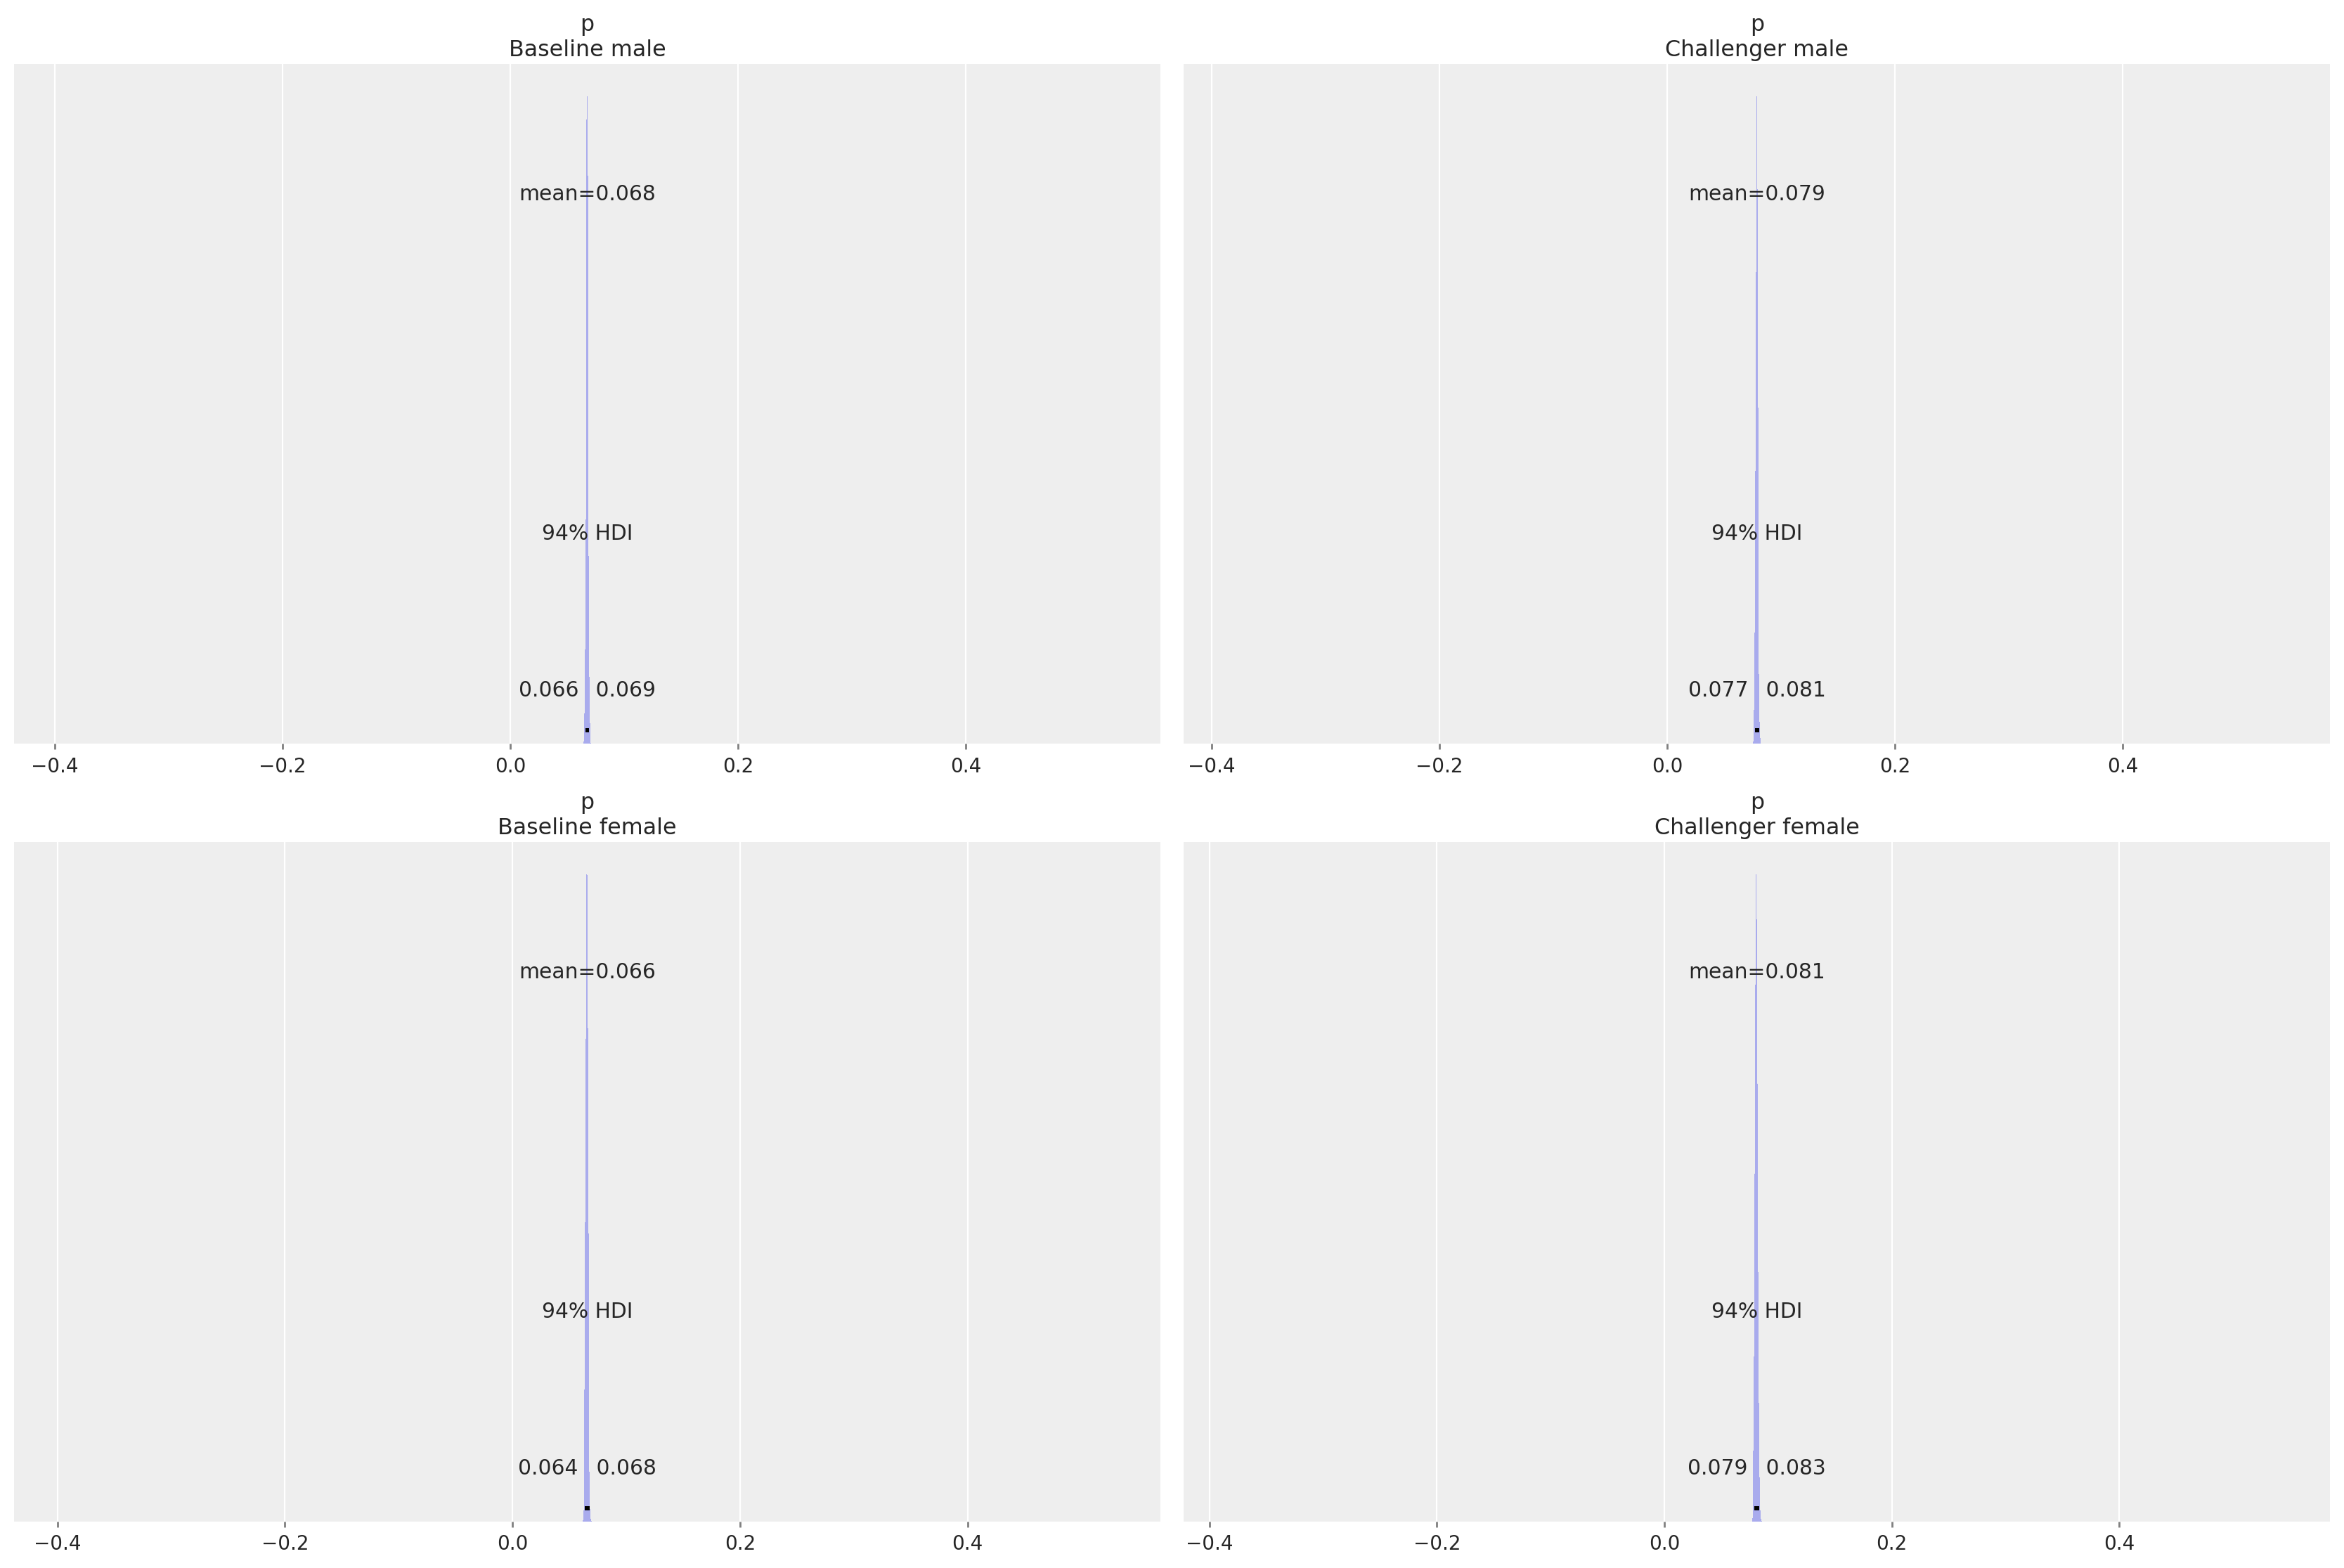

In [10]:
az.plot_posterior(trace_weak.posterior["p"], textsize=10, kind="hist",grid=(2,2))#,grid=(2,2)

"\nfig_123 = plt.gcf()\n#forsteFire = copy.deepcopy(fig_123)\nsisteTo = copy.deepcopy(fig_123)\n#for i in range(1,3):\n    #forsteFire.delaxes(forsteFire.axes[-1])\nfor i in range(0,4):\n    sisteTo.delaxes(sisteTo.axes[-3])\n#forsteFire.savefig('Figures_Bayesian_Analysis/gender_94_credible.png',dpi=200,bbox_inches='tight')\nsisteTo.savefig('Figures_Bayesian_Analysis/gender_uplift.png',dpi=200, bbox_inches='tight')\n"

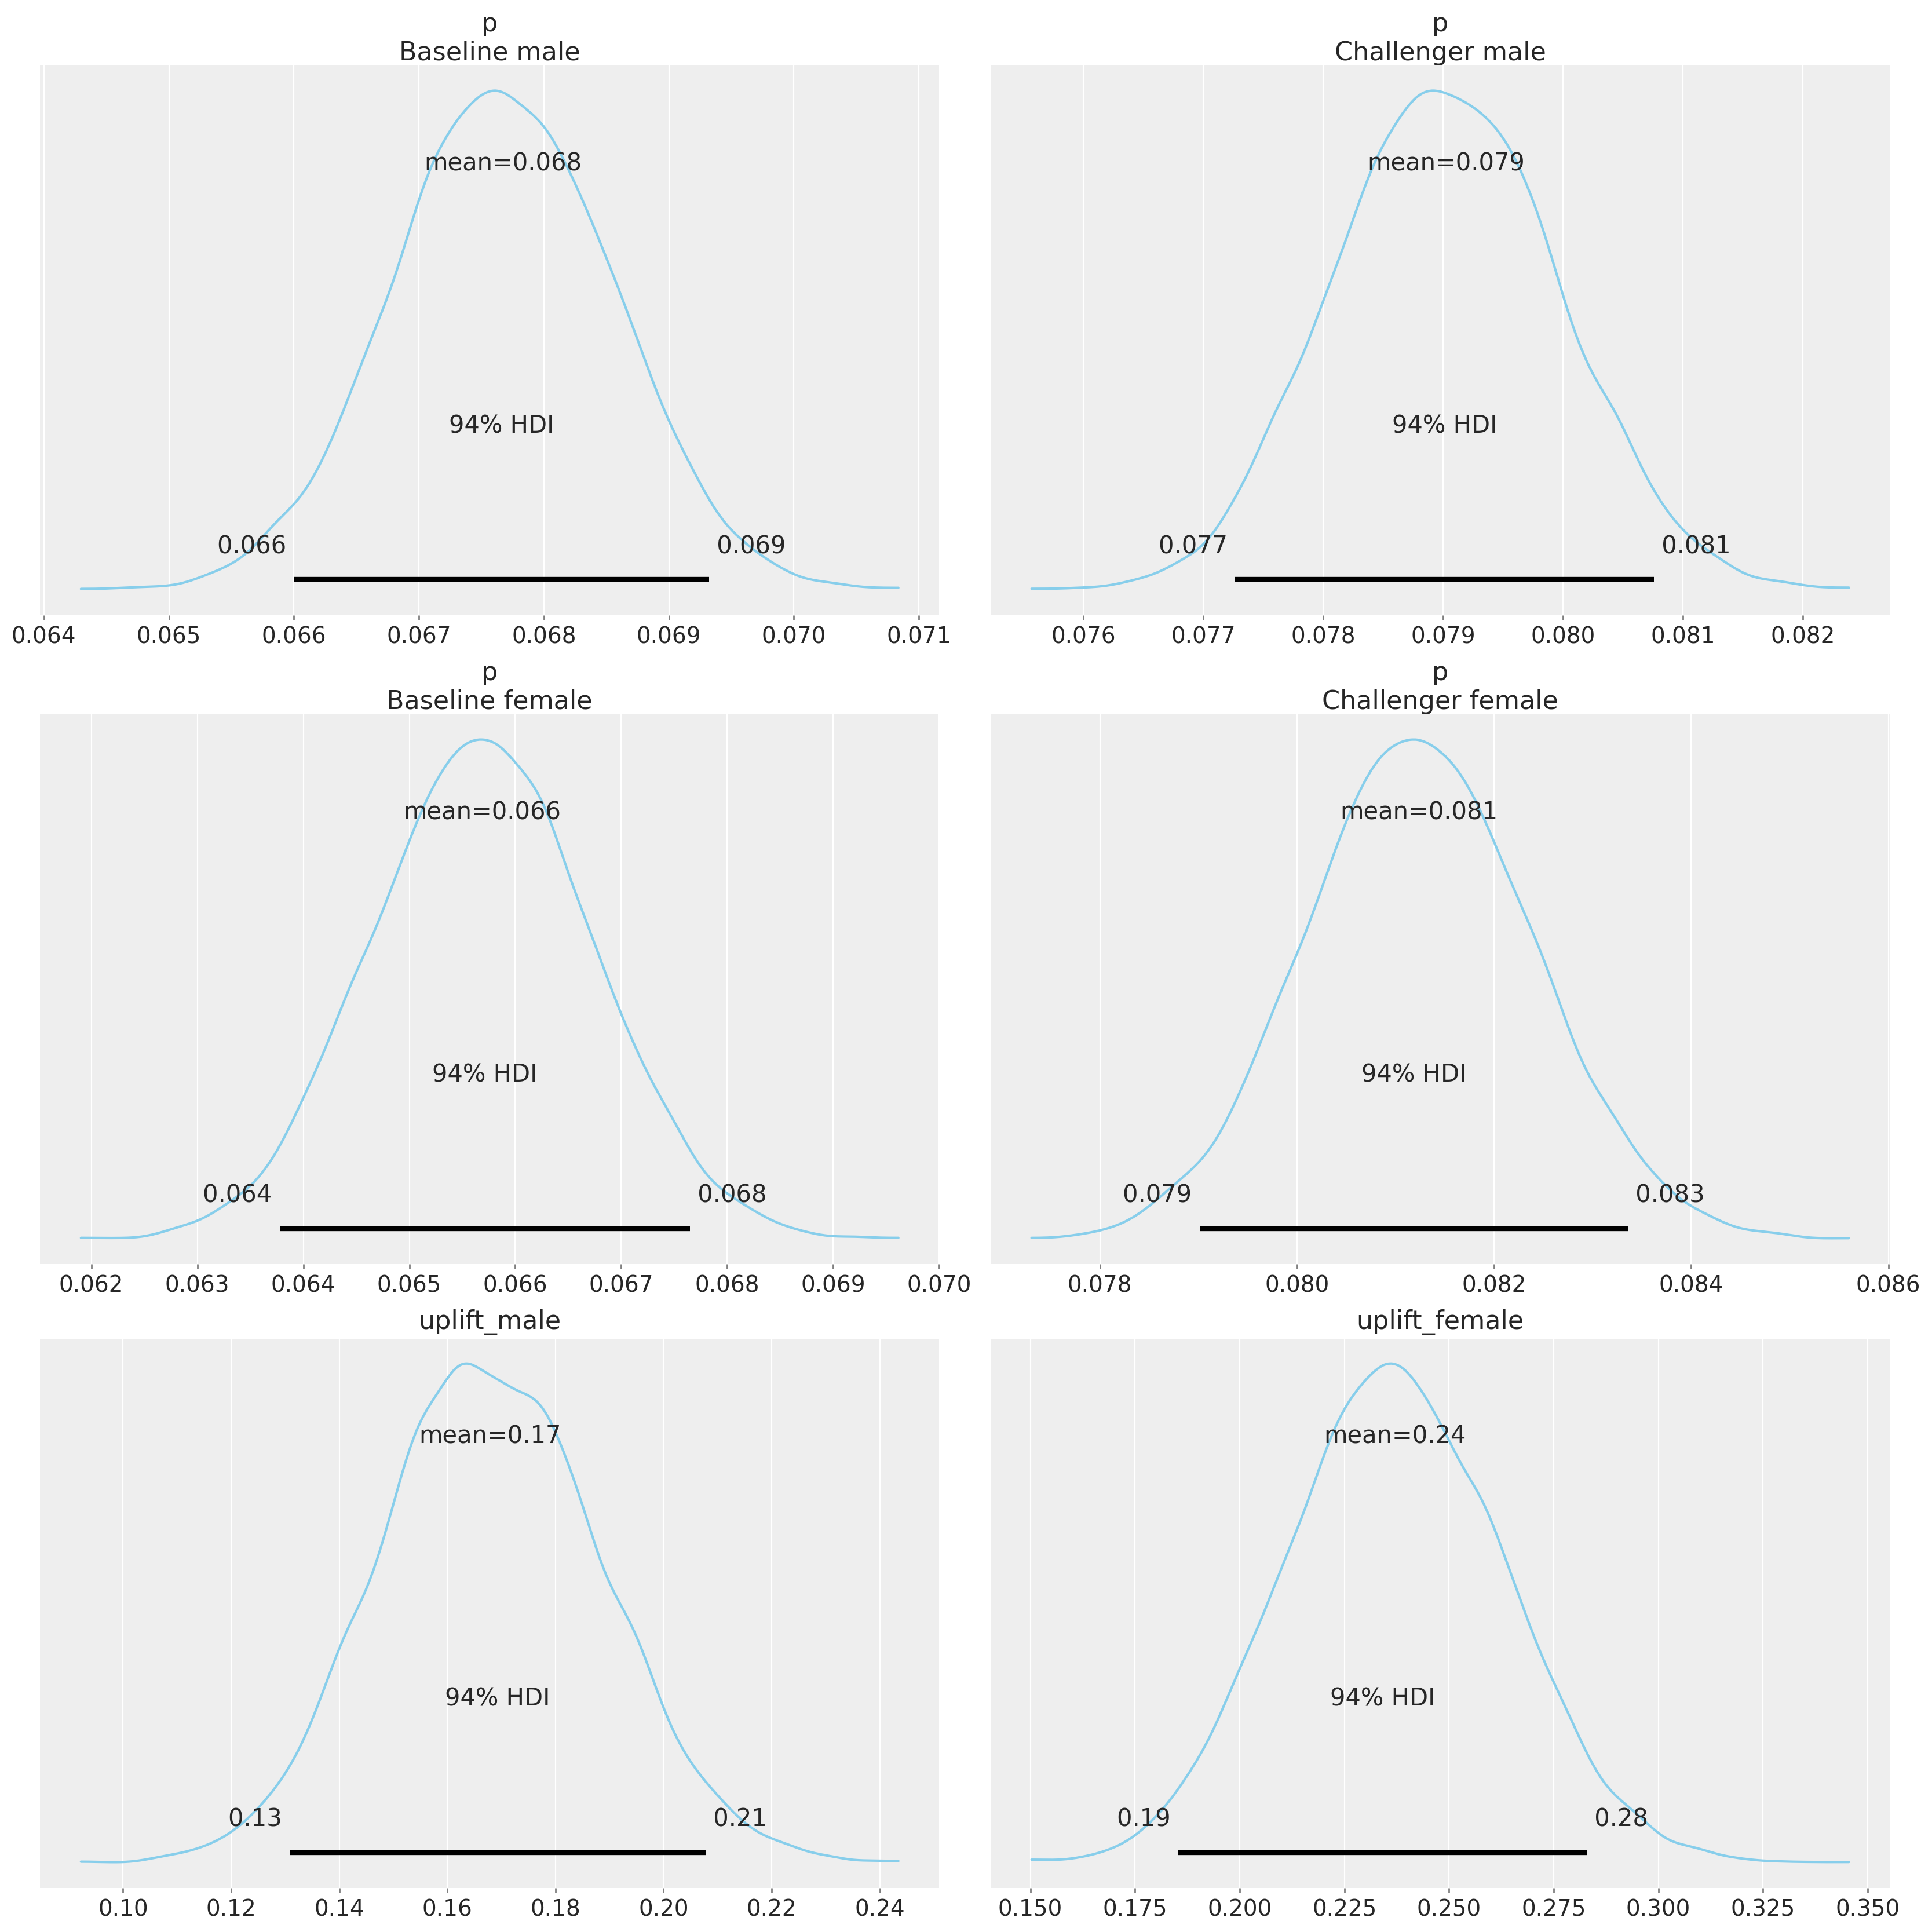

In [11]:
fig = pm.plot_posterior(trace_weak, color = '#87ceeb', grid=(3,2), round_to=2)#,var_names=['p'], grid=(2,2), round_to=4 #, grid=(3,2)
'''
fig_123 = plt.gcf()
#forsteFire = copy.deepcopy(fig_123)
sisteTo = copy.deepcopy(fig_123)
#for i in range(1,3):
    #forsteFire.delaxes(forsteFire.axes[-1])
for i in range(0,4):
    sisteTo.delaxes(sisteTo.axes[-3])
#forsteFire.savefig('Figures_Bayesian_Analysis/gender_94_credible.png',dpi=200,bbox_inches='tight')
sisteTo.savefig('Figures_Bayesian_Analysis/gender_uplift.png',dpi=200, bbox_inches='tight')
'''

In [12]:
men_baseline = [[],[]]
men_challenger = [[],[]]
female_baseline = [[],[]]
female_challenger = [[],[]]
for ind,chain in enumerate(trace_weak.posterior['p'].values):
    for j in chain:
        #print(j)
        men_baseline[ind].append(j[0])
        men_challenger[ind].append(j[1])
        female_baseline[ind].append(j[2])
        female_challenger[ind].append(j[3])

men_baseline = np.array([np.array(x) for x in men_baseline])
men_challenger = np.array([np.array(x) for x in men_challenger])
female_baseline = np.array([np.array(x) for x in female_baseline])
female_challenger = np.array([np.array(x) for x in female_challenger])

In [13]:
print(f'Probability that challenger is better than baseline for men = {(men_challenger > men_baseline).mean():.1%}.')

Probability that challenger is better than baseline for men = 100.0%.


In [14]:
print(f'Probability that challenger is better than baseline for female = {(female_challenger > female_baseline).mean():.1%}.')

Probability that challenger is better than baseline for female = 100.0%.


array([[<AxesSubplot: title={'center': 'p'}>,
        <AxesSubplot: title={'center': 'p'}>],
       [<AxesSubplot: title={'center': 'uplift_male'}>,
        <AxesSubplot: title={'center': 'uplift_male'}>],
       [<AxesSubplot: title={'center': 'uplift_female'}>,
        <AxesSubplot: title={'center': 'uplift_female'}>]], dtype=object)

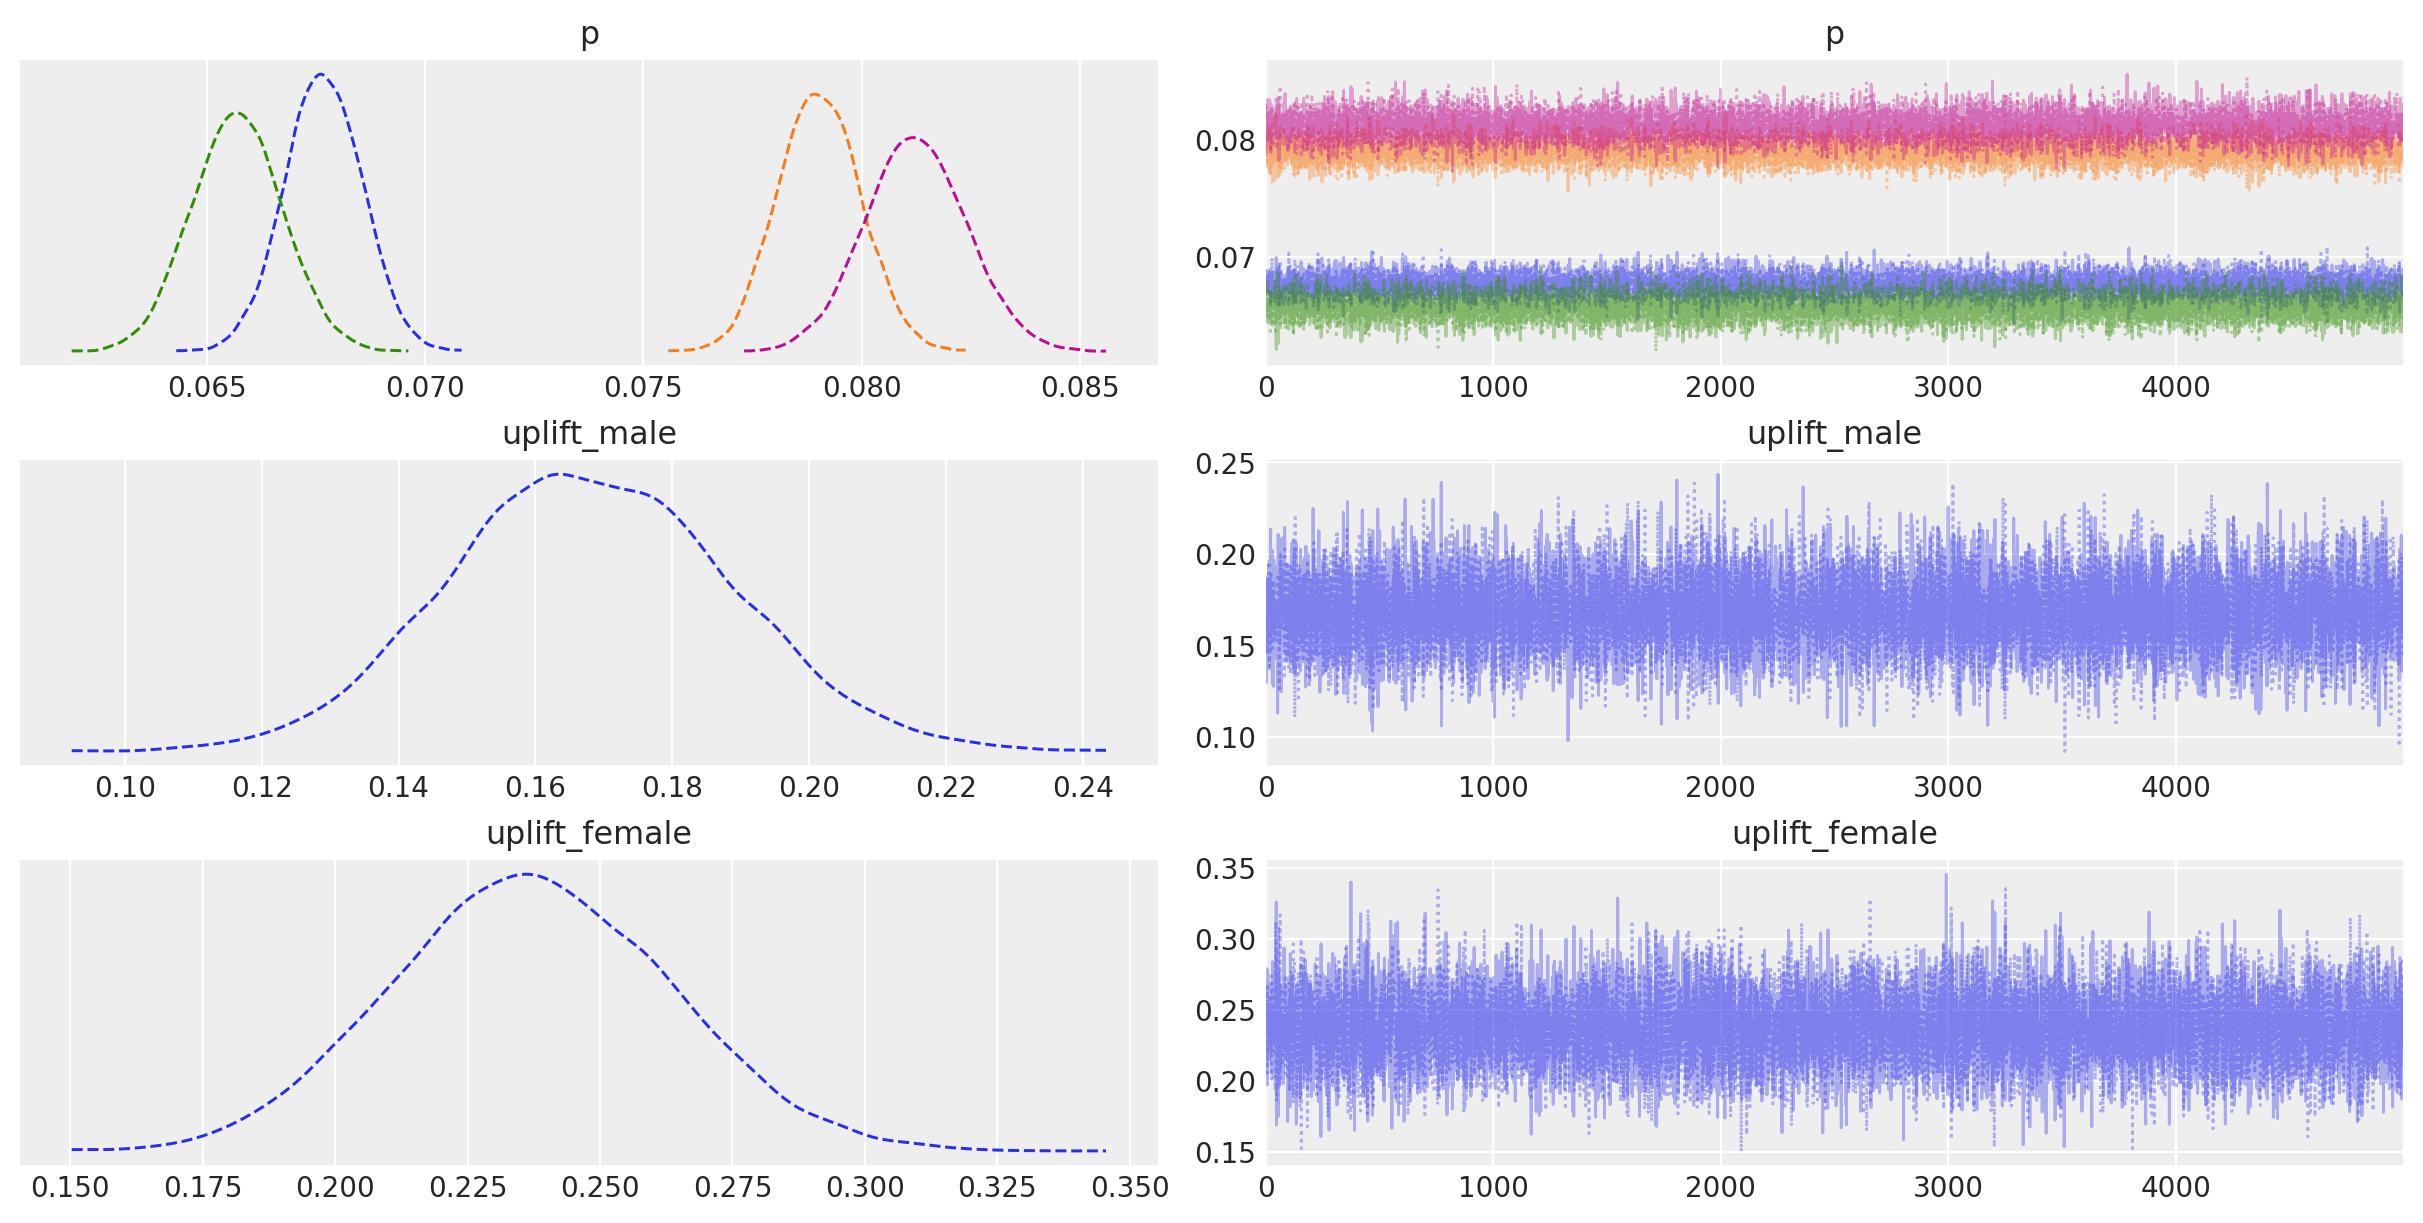

In [15]:
az.plot_trace(
    trace_weak,
    combined=True,
    compact=True,
    coords = {"p_dim_0":groups}
)

array([[<AxesSubplot: title={'center': 'p\nBaseline male'}>,
        <AxesSubplot: title={'center': 'p\nBaseline male'}>],
       [<AxesSubplot: title={'center': 'p\nChallenger male'}>,
        <AxesSubplot: title={'center': 'p\nChallenger male'}>],
       [<AxesSubplot: title={'center': 'p\nBaseline female'}>,
        <AxesSubplot: title={'center': 'p\nBaseline female'}>],
       [<AxesSubplot: title={'center': 'p\nChallenger female'}>,
        <AxesSubplot: title={'center': 'p\nChallenger female'}>],
       [<AxesSubplot: title={'center': 'uplift_male'}>,
        <AxesSubplot: title={'center': 'uplift_male'}>],
       [<AxesSubplot: title={'center': 'uplift_female'}>,
        <AxesSubplot: title={'center': 'uplift_female'}>]], dtype=object)

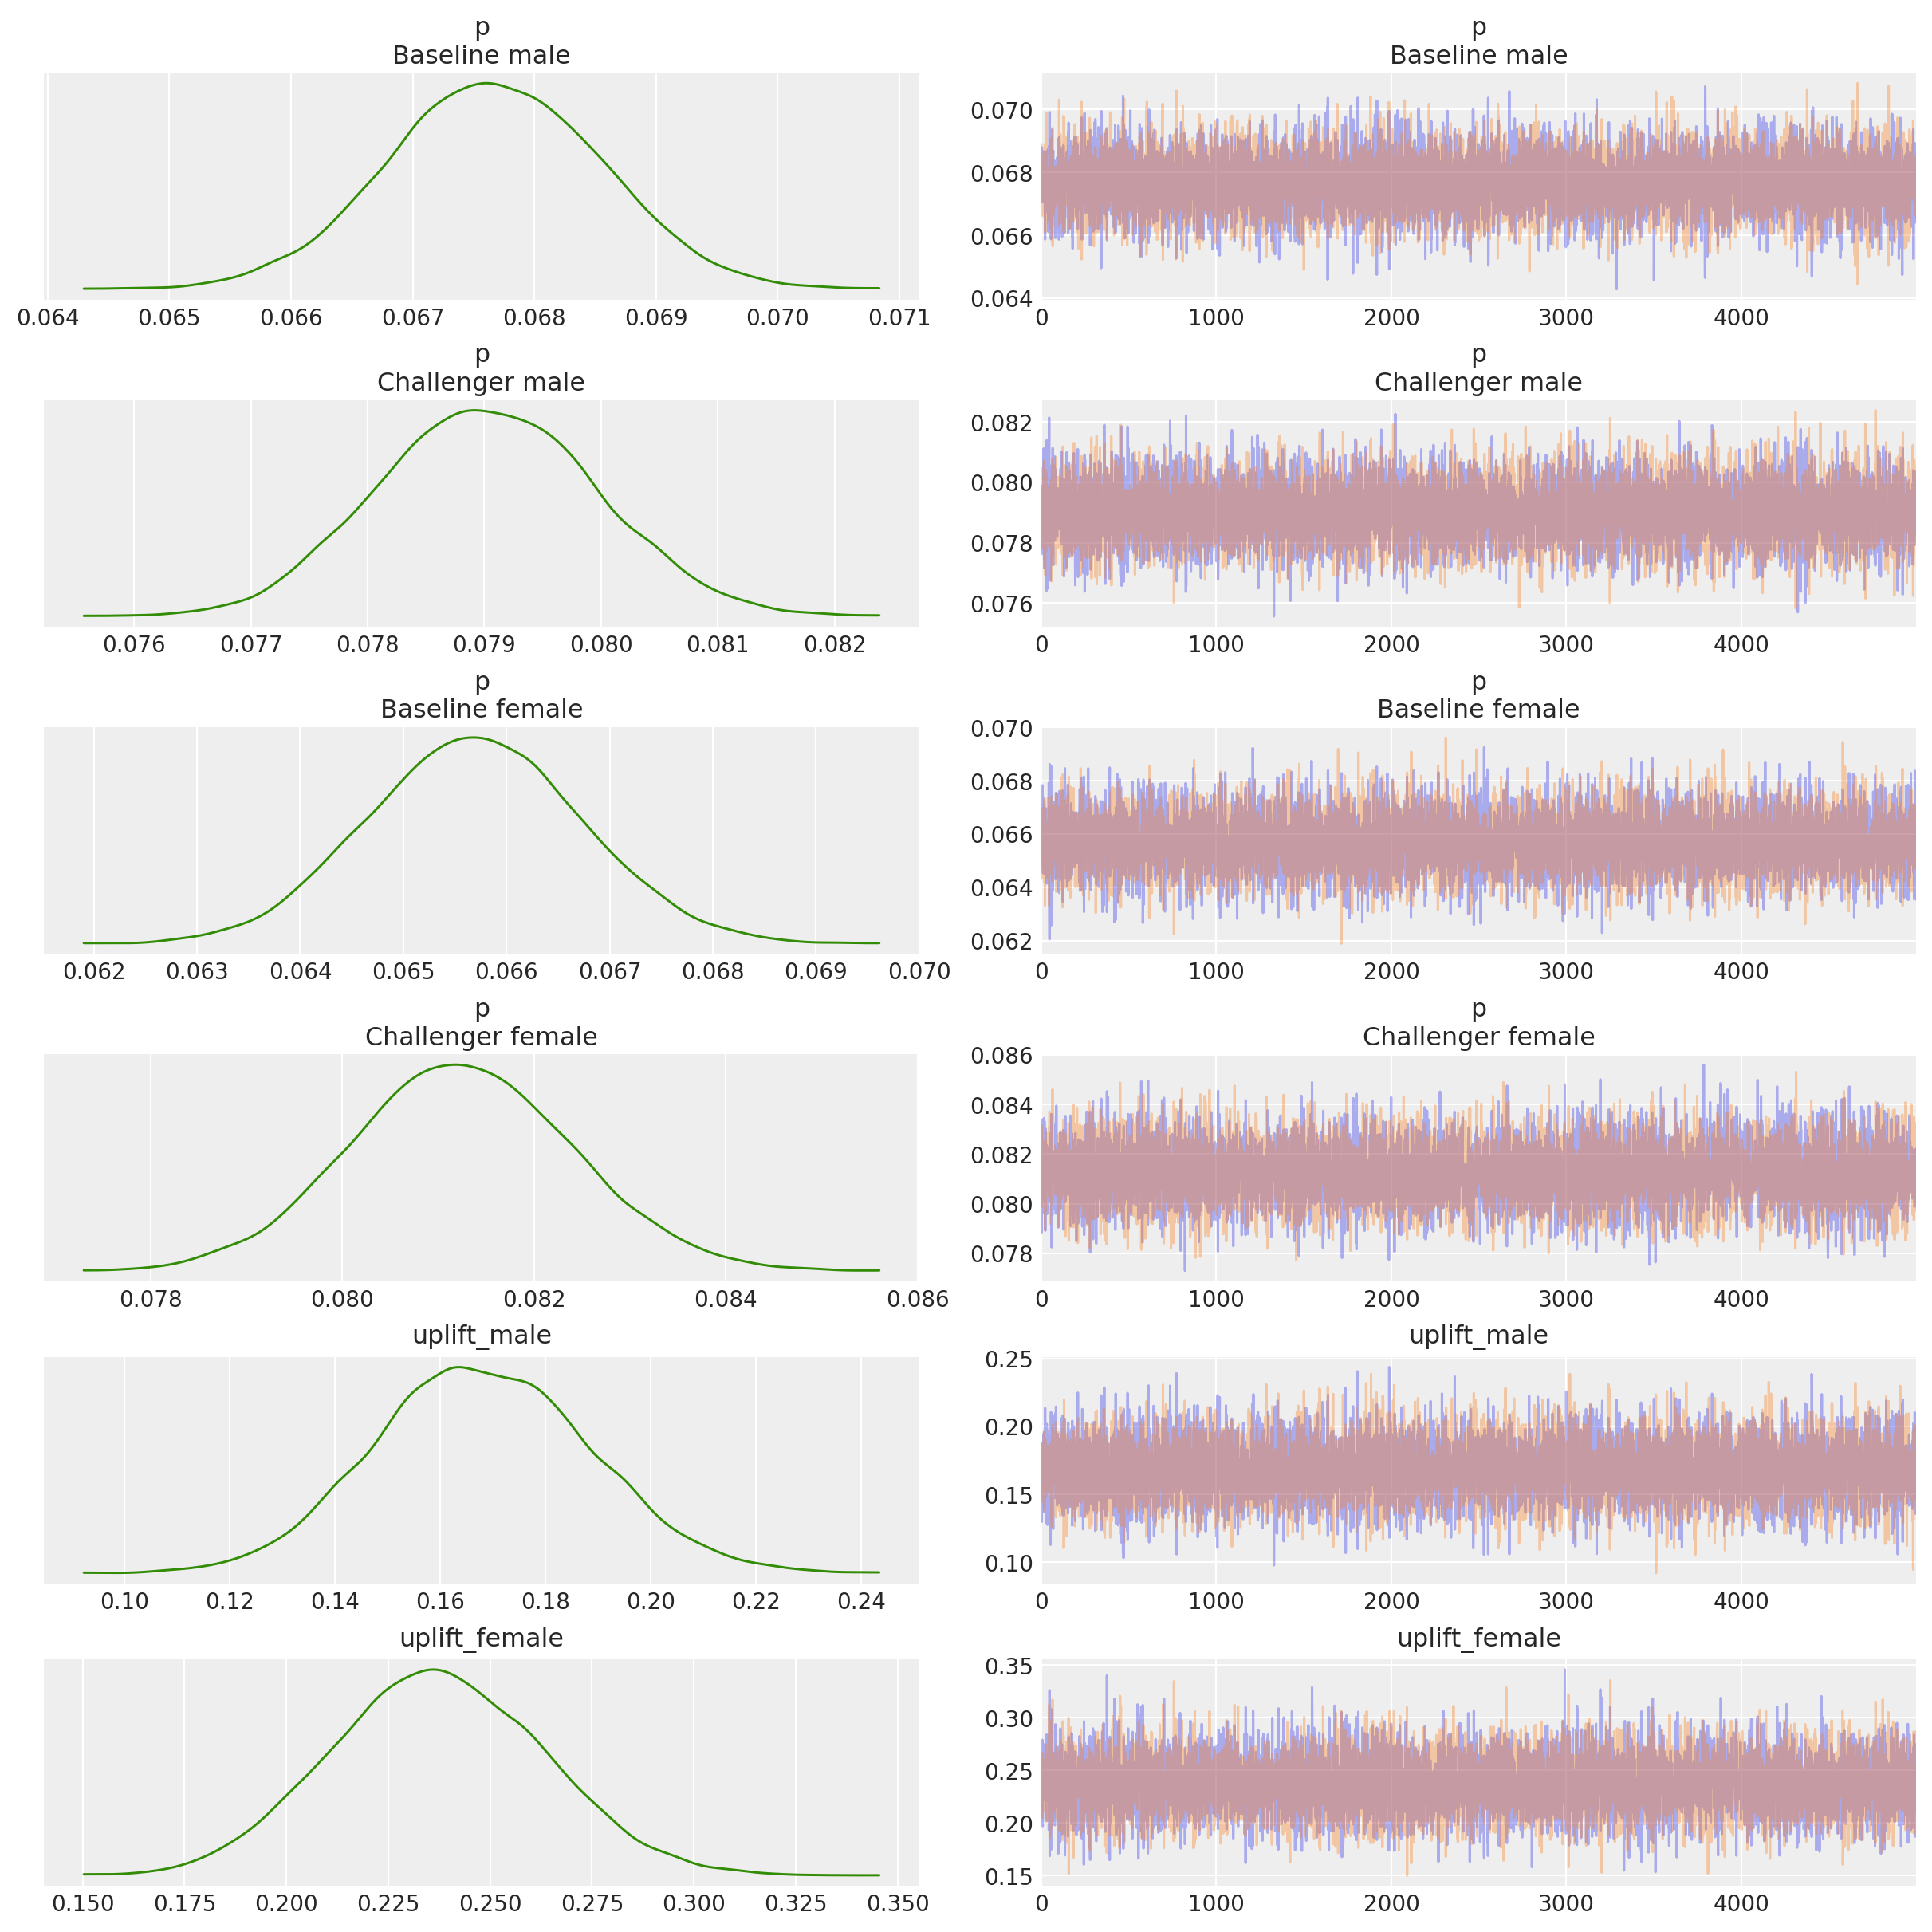

In [16]:
az.plot_trace(
    trace_weak,
    combined=True,
    compact=False,
    coords = {"p_dim_0":groups},
    backend_kwargs={"constrained_layout": True}
)

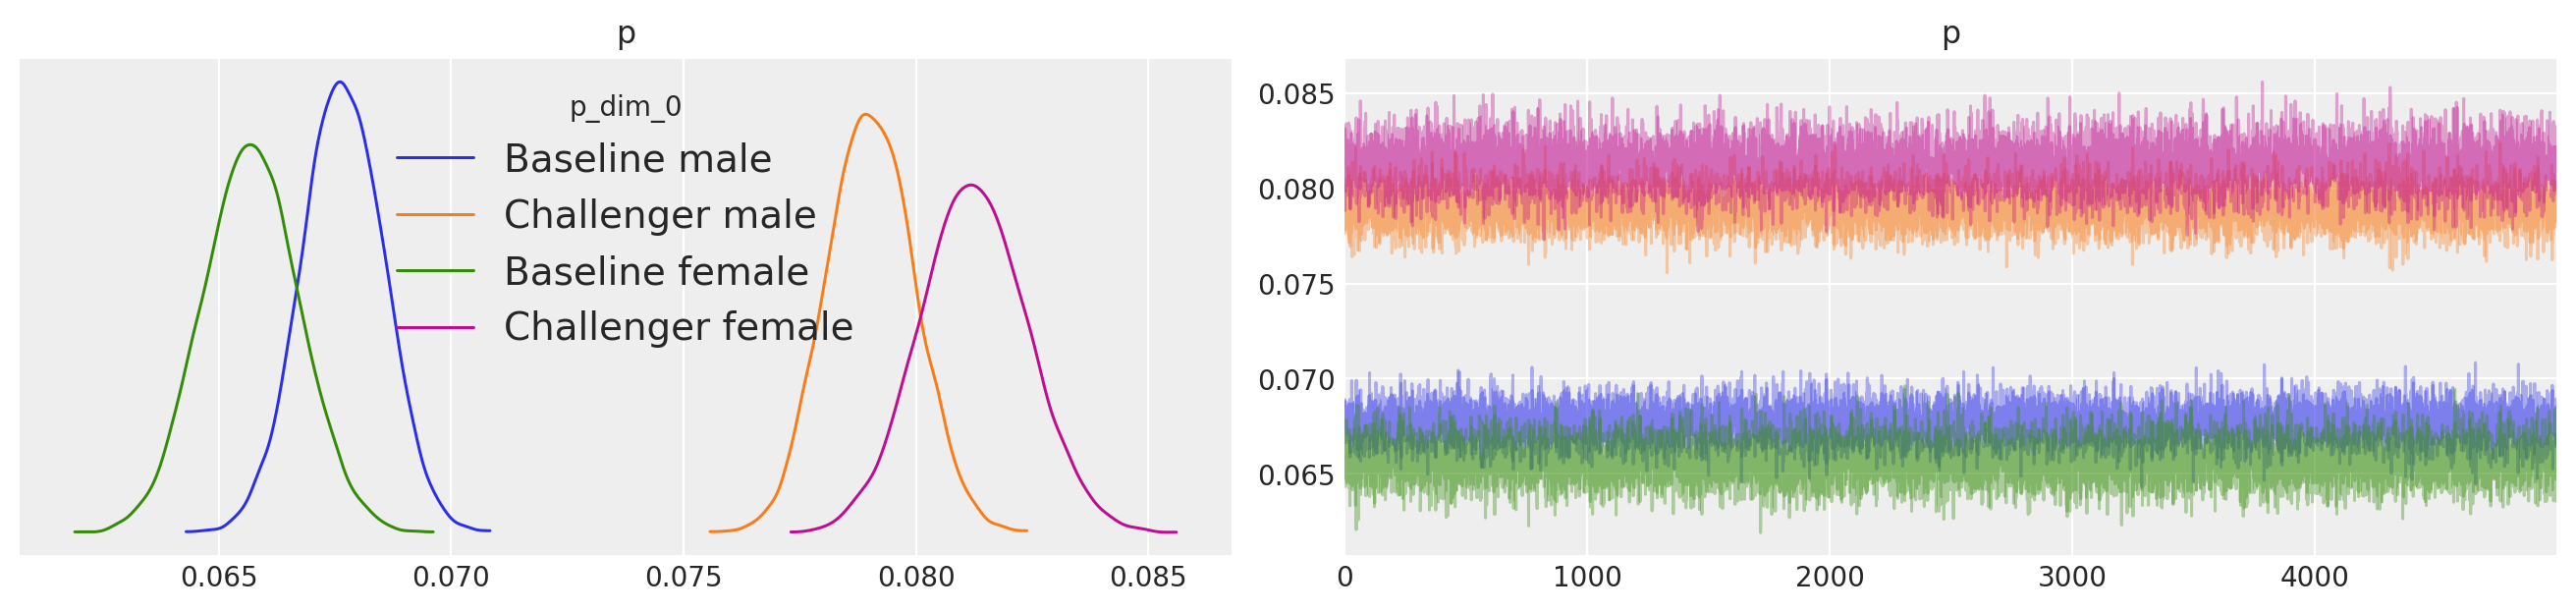

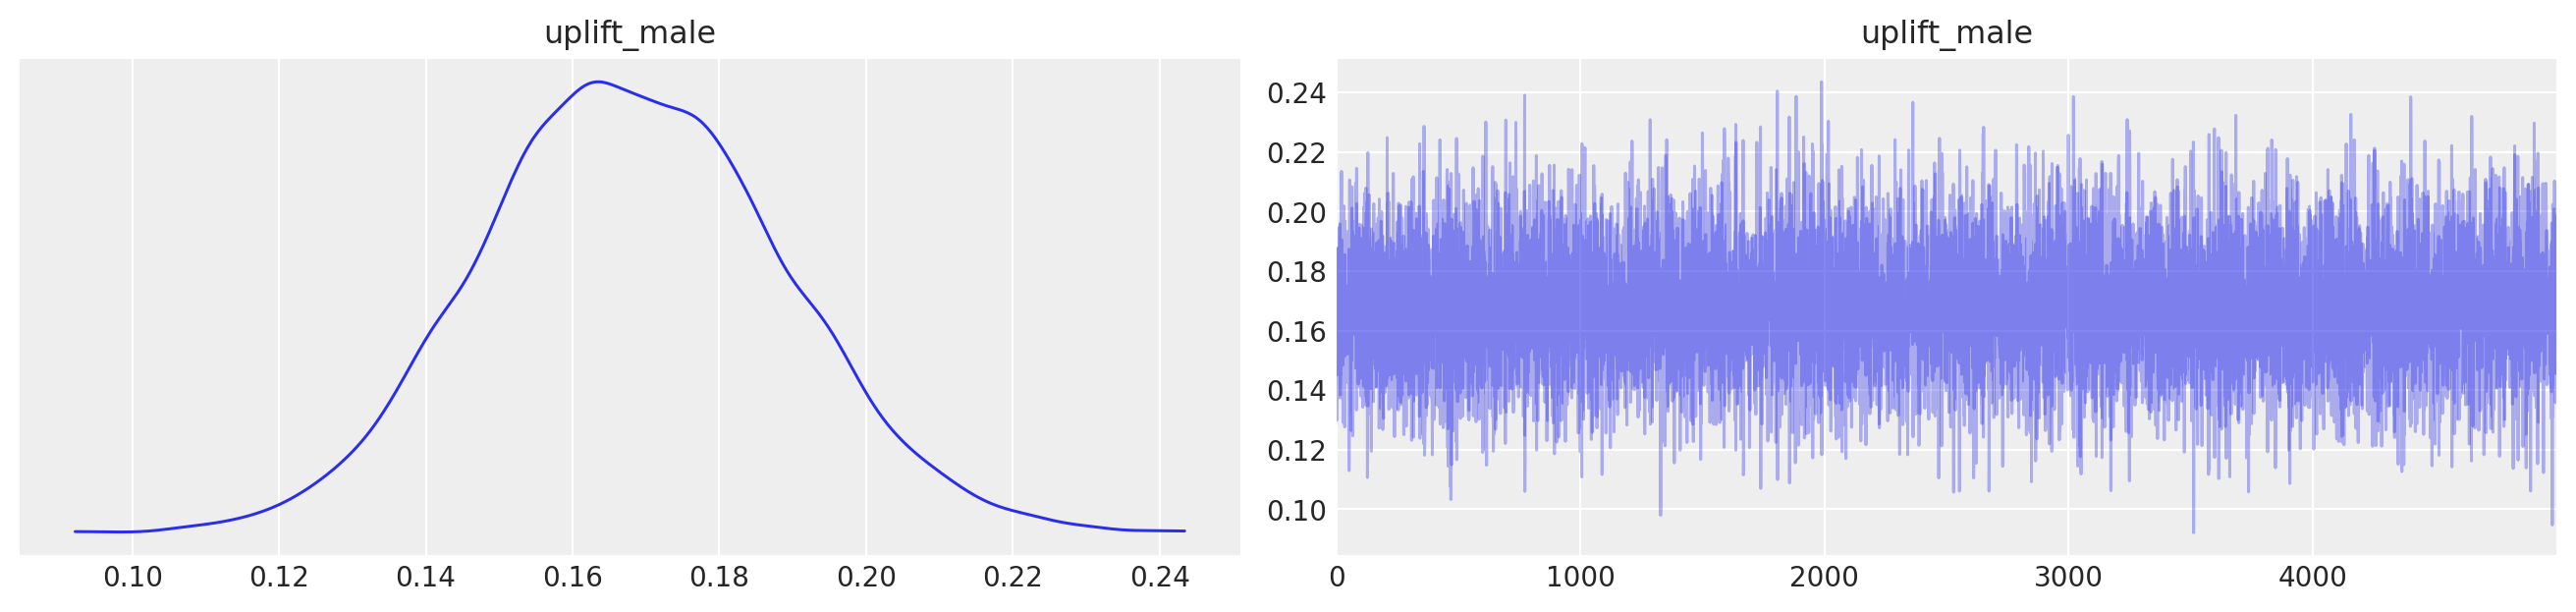

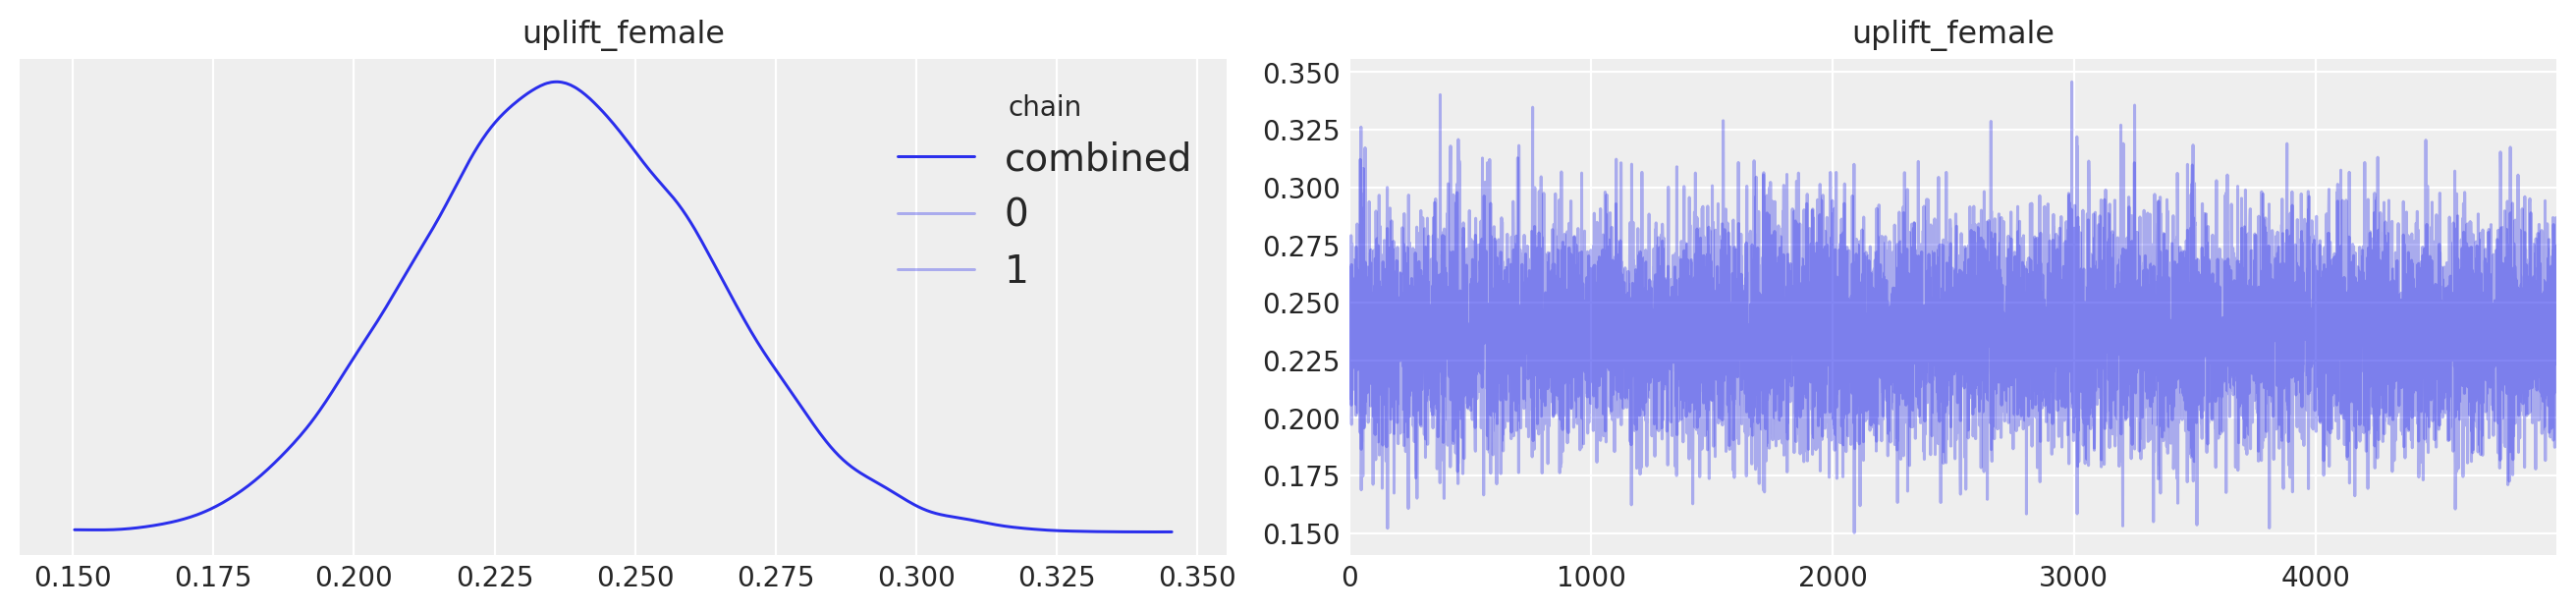

"\nfig1 = copy.deepcopy(_1)\nprint(fig1.axes)\nfig1.delaxes(fig1.axes[1])\nfig1.savefig('Figures_Bayesian_Analysis/gender_distributions.png',dpi=200,bbox_inches='tight')\n"

In [17]:
size = (13, 3)
_1, ax1 = plt.subplots(1, 2, figsize=size)
_2, ax2 = plt.subplots(1, 2, figsize=size)
_3, ax3 = plt.subplots(1, 2, figsize=size)
ax = np.vstack((ax1, ax2, ax3))
az.plot_trace(
    trace_weak, 
    var_names=["p", "uplift_male", "uplift_female"], 
    compact=True,
    combined=True,
    legend=True,
    axes=ax,
    show=True,
    chain_prop={"ls": "-"}
)

'''
fig1 = copy.deepcopy(_1)
print(fig1.axes)
fig1.delaxes(fig1.axes[1])
fig1.savefig('Figures_Bayesian_Analysis/gender_distributions.png',dpi=200,bbox_inches='tight')
'''

In [18]:
summary = az.summary(trace_weak, round_to=3)

In [19]:
text = ''
for i,r in summary.iterrows():
    mean = r['mean']
    sd = r['sd']
    p3 = r['hdi_3%']
    p97 = r['hdi_97%']
    temp = f'{mean} & {sd} & {p3} & {p97}\\\ \n'
    text +=temp
    #print(temp)
    #print(r['mean'])
print(text)

0.068 & 0.001 & 0.066 & 0.069\\ 
0.079 & 0.001 & 0.077 & 0.081\\ 
0.066 & 0.001 & 0.064 & 0.068\\ 
0.081 & 0.001 & 0.079 & 0.083\\ 
0.168 & 0.021 & 0.131 & 0.208\\ 
0.237 & 0.026 & 0.185 & 0.283\\ 

